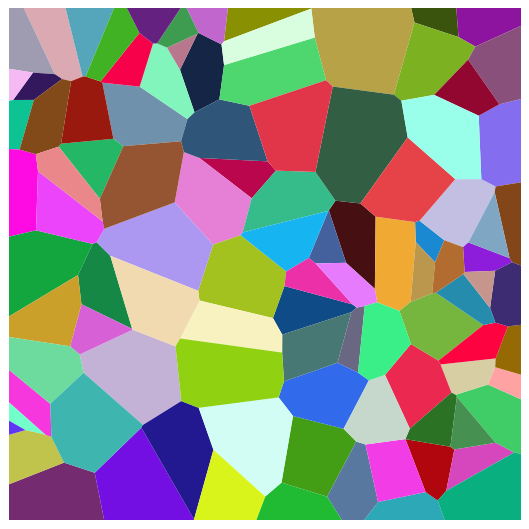

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions, new_vertices = [], vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    for p1, region in enumerate(vor.point_region):
        verts = vor.regions[region]
        if verts and all(v >= 0 for v in verts):
            new_regions.append(verts)
            continue
        new_region = [v for v in verts if v >= 0]
        for p2, v1, v2 in all_ridges[p1]:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue
            t = vor.points[p2] - vor.points[p1]; t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        ang = np.arctan2(vs[:,1]-c[1], vs[:,0]-c[0])
        new_regions.append(np.array(new_region)[np.argsort(ang)].tolist())
    return new_regions, np.asarray(new_vertices)

# ----------------- MAIN -----------------
N_GRAIN = 
SEED = 200
OUTPUT_PX = 512        # <-- square output size in pixels (e.g., 1024, 2048, 4096)

np.random.seed(SEED)
points = np.random.rand(N_GRAIN, 2)
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

# random vivid colors per cell
colors = np.random.rand(N_GRAIN, 3)

# --- Build a square canvas with exact OUTPUT_PX x OUTPUT_PX ---
inch = 6.0
dpi = OUTPUT_PX / inch
fig = plt.figure(figsize=(inch, inch), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1])     # fill entire figure (no margins)

# draw cells
for i, region in enumerate(regions):
    poly = vertices[region]
    ax.fill(*zip(*poly), facecolor=colors[i % len(colors)], edgecolor="none")

# square domain and no axes
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect("equal")
ax.set_axis_off()

# transparent background, fixed pixel size (no bbox cropping!)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
fig.savefig(f'./image/voronoi_{N_GRAIN}.png', transparent=True)
